In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib import pyplot as plt
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances_argmin_min
import getpass


In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="170d500451dc4520965b237c4e9a28fc",client_secret=getpass.getpass(prompt='client_secret: ')))

client_secret: ········


# functions

In [3]:
#a function that returns scaled colection and sample song
def scal2(data, sample):
    scaler = StandardScaler()
    scaler.fit(data)
    
    return(scaler.transform(data),scaler.transform(sample))

    

In [4]:
# Returns K value
def Kcalculator(data):
    visualizer = KElbowVisualizer(KMeans(), k=(2,20))
    visualizer.fit(data)    # Fit the data to the visualizer
    visualizer.show()    # Draw/sh
    return(visualizer.elbow_value_)

In [5]:
#a function that returns clusters for colection and sample song
def clust(colection, sample):
    K = Kcalculator(colection)
    print('K value: ',K)
    x1, x2 = scal2(colection,sample)
    kmeans = KMeans(K, random_state=42)
    kmeans.fit(x1)
    return(kmeans.predict(x1),kmeans.predict(x2))

In [6]:
#returns a df with data from the selector cluster
def slicer(data, cluster, selector):
    data2 = data.copy()
    data2['cluster']= cluster
    data2 = data2[data2['cluster']==selector[0]]
    
    return(data2.drop('cluster', axis=1))
    

In [7]:
#recursive fuction, returns a sublcluster of the colection with less than 20 elements
def rec(colection, sample):
    if len(colection)>20:
        
        cl1,cl2 = clust(colection,sample)
        
        newdata = slicer(colection,cl1,cl2)
        print('new cluster size: ',len(newdata))
        result = rec(newdata,sample)
    else:
        result=colection
    return(result)


In [8]:
#uses data returned from the recursive fuction to return the nearest neighbor
def predictor(colection,sample,df):
    selection = rec(colection,sample)
    #print(selection)
    norm_selection,norm_track = scal2(selection,sample)
    closest, _ = pairwise_distances_argmin_min(norm_track, norm_selection)
    final = df.loc[selection.index[closest]].id
    return(final)

In [9]:
#if the songid is in the collection df, returns a df without that song
def inlist(data,songid):
    return(data[data.id != songid])
    

In [10]:
#front end, asks for a song amd returns the sugested song_id
def front(data):
    # get song id
    song_name = input('Choose a song: ')
    results = sp.search(q=f'track:{song_name}', limit=1)
    track_id = results['tracks']['items'][0]['id']
    printdata(track_id)
    track = pd.DataFrame(sp.audio_features(track_id)).select_dtypes(include='number')
    
    
    num = inlist(data,track_id).select_dtypes(include='number')
    print('Song pool size: ', len(num))
    predicted=predictor(num,track,data)
    
    printdata(predicted.tolist()[0])
    return(predicted)

In [11]:
#prints song data from a song_id
def printdata(song):
    info = sp.track(song)
    print('Track_ID:',song)
    #artist name
    print('Artist: ',info['artists'][0]['name'])
    #album name
    print('Album:  ',info['album']['name'])
    #song name
    print('Song:   ',info['name'])
    #song url
    print('Link:   ',info['external_urls']['spotify'])

# Main


In [12]:
#load the collection data
data2 = pd.read_csv ('./data/collection.csv')

Choose a song: toxic
Track_ID: 6I9VzXrHxO9rA9A5euc8Ak
Artist:  Britney Spears
Album:   In The Zone
Song:    Toxic
Link:    https://open.spotify.com/track/6I9VzXrHxO9rA9A5euc8Ak
Song pool size:  5290


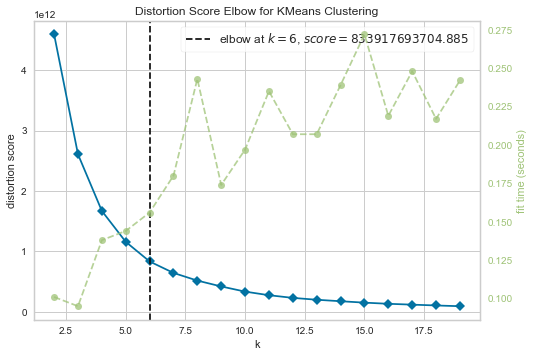

K value:  6
new cluster size:  1522


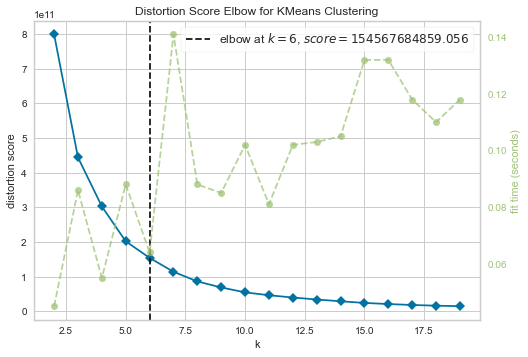

K value:  6
new cluster size:  380


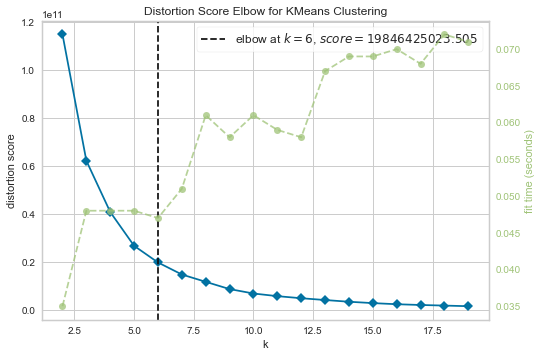

K value:  6
new cluster size:  77


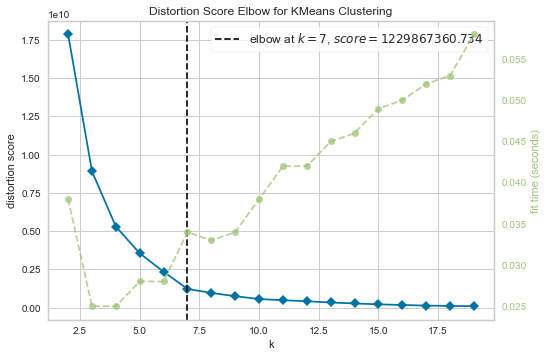

K value:  7
new cluster size:  2
Track_ID: 6kZPtpO12FBAgkK4Cf0v18
Artist:  Todiefor
Album:   Tunak Tunak Tun (Remix) (feat. Daler Mehndi)
Song:    Tunak Tunak Tun (Remix) (feat. Daler Mehndi)
Link:    https://open.spotify.com/track/6kZPtpO12FBAgkK4Cf0v18


In [13]:
predicted = front(data2)